In [1]:
import os
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.sparse as sp
import time
import gget
import anndata as an
import scanpy as sc
import scanpy.external as sce
import h5py
import scipy
from scipy.stats import median_abs_deviation
from scipy.stats import pearsonr


sc.settings.verbosity = 2
sc.logging.print_header()

scanpy==1.10.4 anndata==0.11.4 umap==0.5.7 numpy==1.26.4 scipy==1.15.2 pandas==2.2.3 scikit-learn==1.6.1 statsmodels==0.14.4 igraph==0.11.6 pynndescent==0.5.13


# Load in the data

In [2]:
start = time.perf_counter()

path = "/nfs/turbo/umms-indikar/shared/projects/hybrid_reprogramming/anndata/raw_merged_gene_data.h5ad"

adata_raw = sc.read_h5ad(path)
print(f"Initial shape: {adata_raw.shape}\n")
print(f"N cells in HYB dataset: {adata_raw[adata_raw.obs['dataset'] == 'Hybrid'].n_obs}")
print(f"N cells in scFib dataset: {adata_raw[adata_raw.obs['dataset'] == 'Control'].n_obs}\n")

sc.logging.print_memory_usage() # Log memory at the end

print(f"Total time: {time.perf_counter() - start:.2f} seconds")

adata_raw

Initial shape: (19858, 28702)

N cells in HYB dataset: 10895
N cells in scFib dataset: 8963

Memory usage: current 1.22 GB, difference +1.22 GB
Total time: 2.14 seconds


AnnData object with n_obs × n_vars = 19858 × 28702
    obs: 'MYOD-fb_counts', 'PRRX1-fb_counts', 'PRRX1_MYOD-fb_counts', 'assigned_condition', 'total_fb_counts', 'condition_counts_rate', 'G1-fb_counts', 'G2M-fb_counts', 'S-fb_counts', 'dataset', 'total_reads', 'total_genes'
    var: 'gene_id', 'gene_type', 'Chromosome', 'Start', 'End'

In [3]:
### --- Handle HYB cells with NaN feature barcode predictions ---
init_cells_hybrid = adata_raw[adata_raw.obs['dataset'] == 'Hybrid'].n_obs

# remove HYB cells with NaN feature barcode predictions
hybrid_to_remove = (adata_raw.obs['dataset'] == 'Hybrid') & (adata_raw.obs['assigned_condition'].isna())
cells_to_keep = ~(hybrid_to_remove)
adata_raw = adata_raw[cells_to_keep].copy()

final_cells_hybrid = adata_raw[adata_raw.obs['dataset'] == 'Hybrid'].n_obs
removed_hybrid_cells = init_cells_hybrid - final_cells_hybrid

print(f"Removed {removed_hybrid_cells} 'Hybrid' cells with unassigned feature barcodes")
print(f"Final shape: {adata_raw.shape}")


### --- Add new column for grouping HYB cells vs Controls ---
adata_raw.obs['pooled_condition'] = adata_raw.obs['assigned_condition'].replace({
    "G1": "Control",
    "S": "Control",
    "G2M": "Control",
    "PRRX1": "siPRRX1",
    "PRRX1_MYOD": "siPRRX1/mmMYOD1",
    "MYOD": "mmMYOD1"
})

# fill remaining NaN feature barcode predictions (only control cells) with 'Control'
adata_raw.obs['pooled_condition'] = adata_raw.obs['pooled_condition'].fillna('Control')
print(adata_raw.obs['pooled_condition'].value_counts())

adata_raw

Removed 1 'Hybrid' cells with unassigned feature barcodes
Final shape: (19857, 28702)
pooled_condition
Control            8963
siPRRX1/mmMYOD1    4174
siPRRX1            3955
mmMYOD1            2765
Name: count, dtype: int64


/tmp/ipykernel_147320/1807916870.py:17: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  adata_raw.obs['pooled_condition'] = adata_raw.obs['assigned_condition'].replace({


AnnData object with n_obs × n_vars = 19857 × 28702
    obs: 'MYOD-fb_counts', 'PRRX1-fb_counts', 'PRRX1_MYOD-fb_counts', 'assigned_condition', 'total_fb_counts', 'condition_counts_rate', 'G1-fb_counts', 'G2M-fb_counts', 'S-fb_counts', 'dataset', 'total_reads', 'total_genes', 'pooled_condition'
    var: 'gene_id', 'gene_type', 'Chromosome', 'Start', 'End'

(19857, 3)


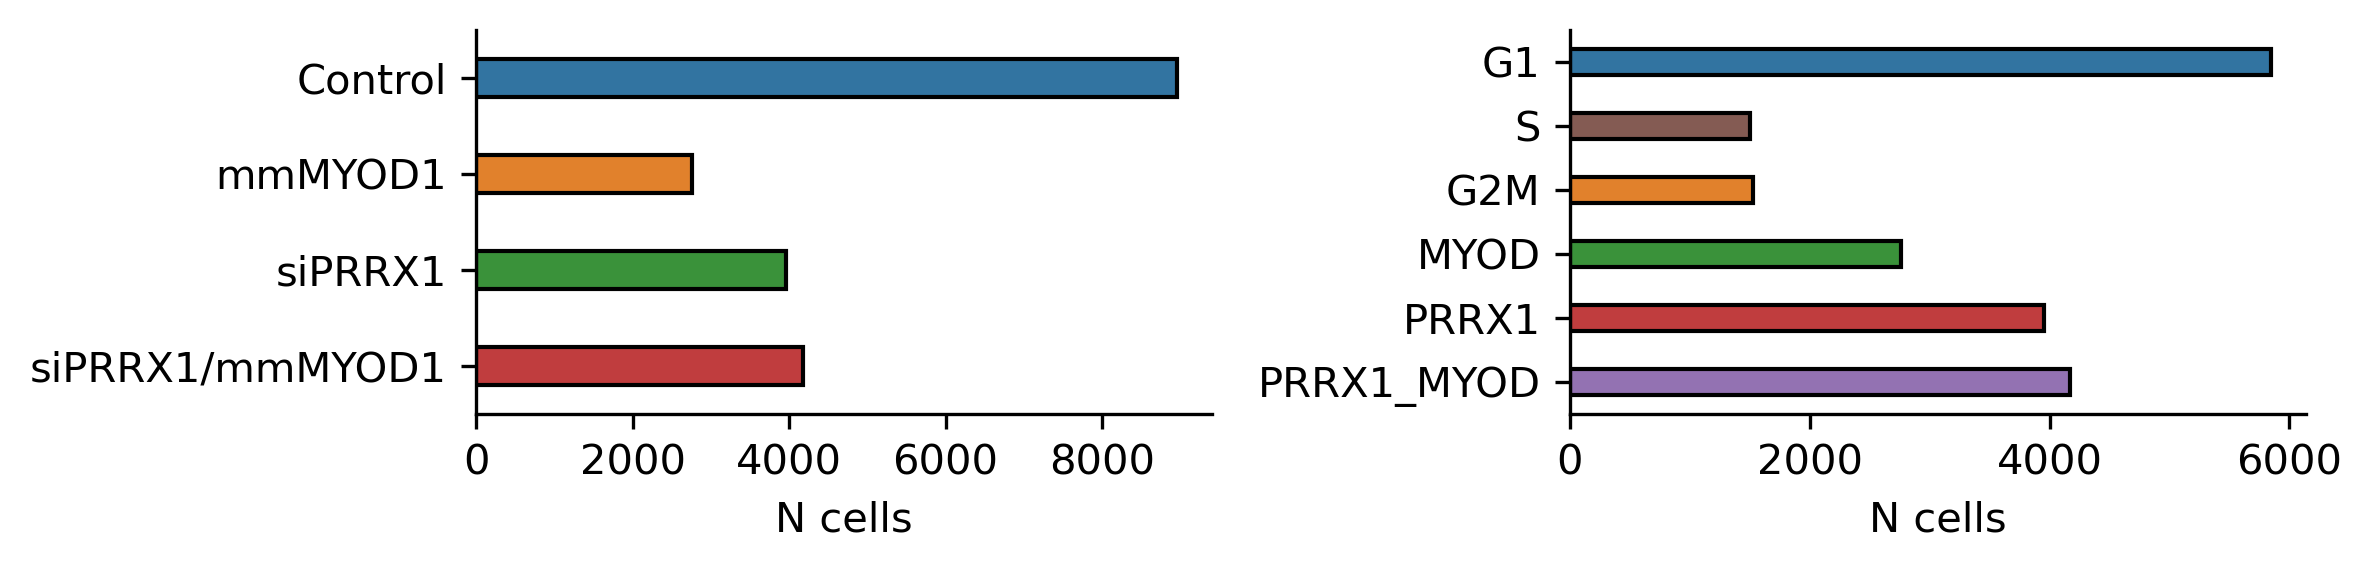

In [4]:
counts = pd.DataFrame({
    'cell_id': adata_raw.obs.index,
    'pooled_condition': adata_raw.obs['pooled_condition'].values,
    'assigned_condition': adata_raw.obs['assigned_condition'].values,
})

print(counts.shape)

pool_df = counts.groupby('pooled_condition', observed=True).size().reset_index(name='cell_count')

barcode_df = counts.groupby('assigned_condition', observed=True).size().reset_index(name='cell_count')


plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 8, 2
fig, axs = plt.subplots(1, 2)

sns.barplot(data=pool_df, x='cell_count', y='pooled_condition', hue='pooled_condition', width=0.4, ec='k', ax=axs[0])
    
sns.barplot(data=barcode_df, x='cell_count', y='assigned_condition', hue='assigned_condition', width=0.4, ec='k', ax=axs[1],
           order=['G1', 'S', 'G2M', 'MYOD', 'PRRX1', 'PRRX1_MYOD'])

axs[0].set_ylabel("")
axs[1].set_ylabel("")
axs[0].set_xlabel("N cells")
axs[1].set_xlabel("N cells")

sns.despine()
plt.tight_layout()
plt.show()

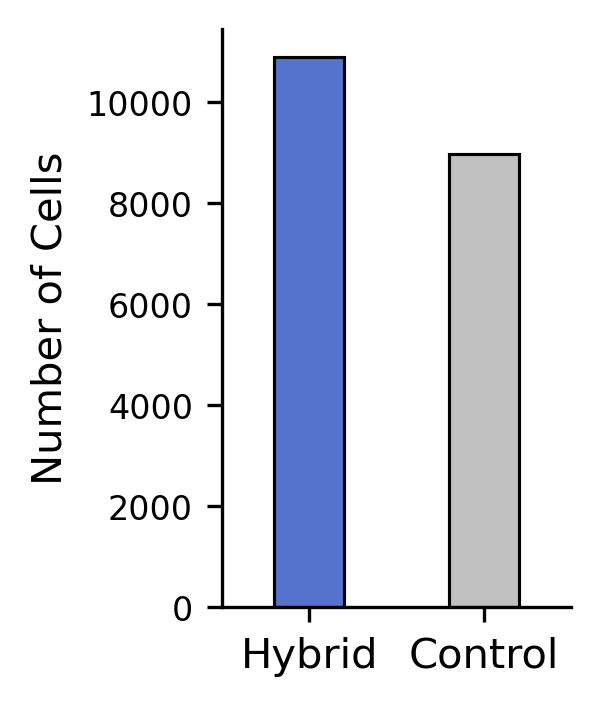

In [14]:
plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 1.5, 2.5
fig, axs = plt.subplots()

dataset_colors = ["royalblue", "silver"]

sns.countplot(data=adata_raw.obs,
            x='dataset',
            hue='dataset',
            width=0.4,
            ec='k',
            linewidth=0.75,
            palette=dataset_colors,
           )

plt.ylabel("Number of Cells")
plt.xlabel("")

plt.yticks(fontsize=8)

sns.despine()
plt.show()

# QC

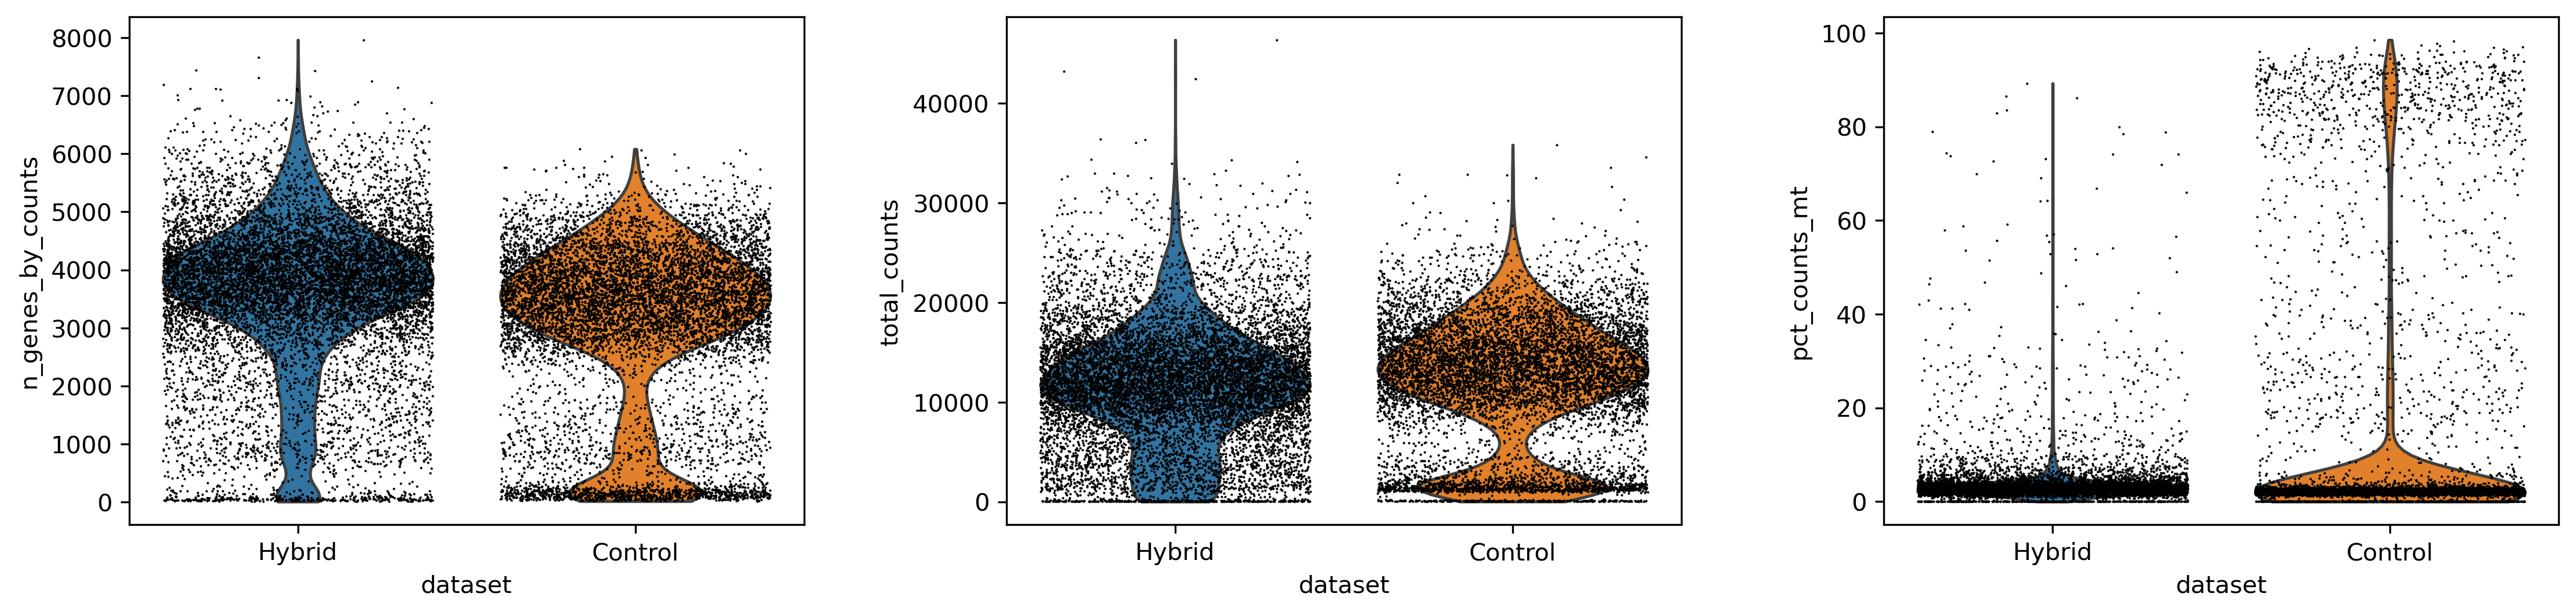

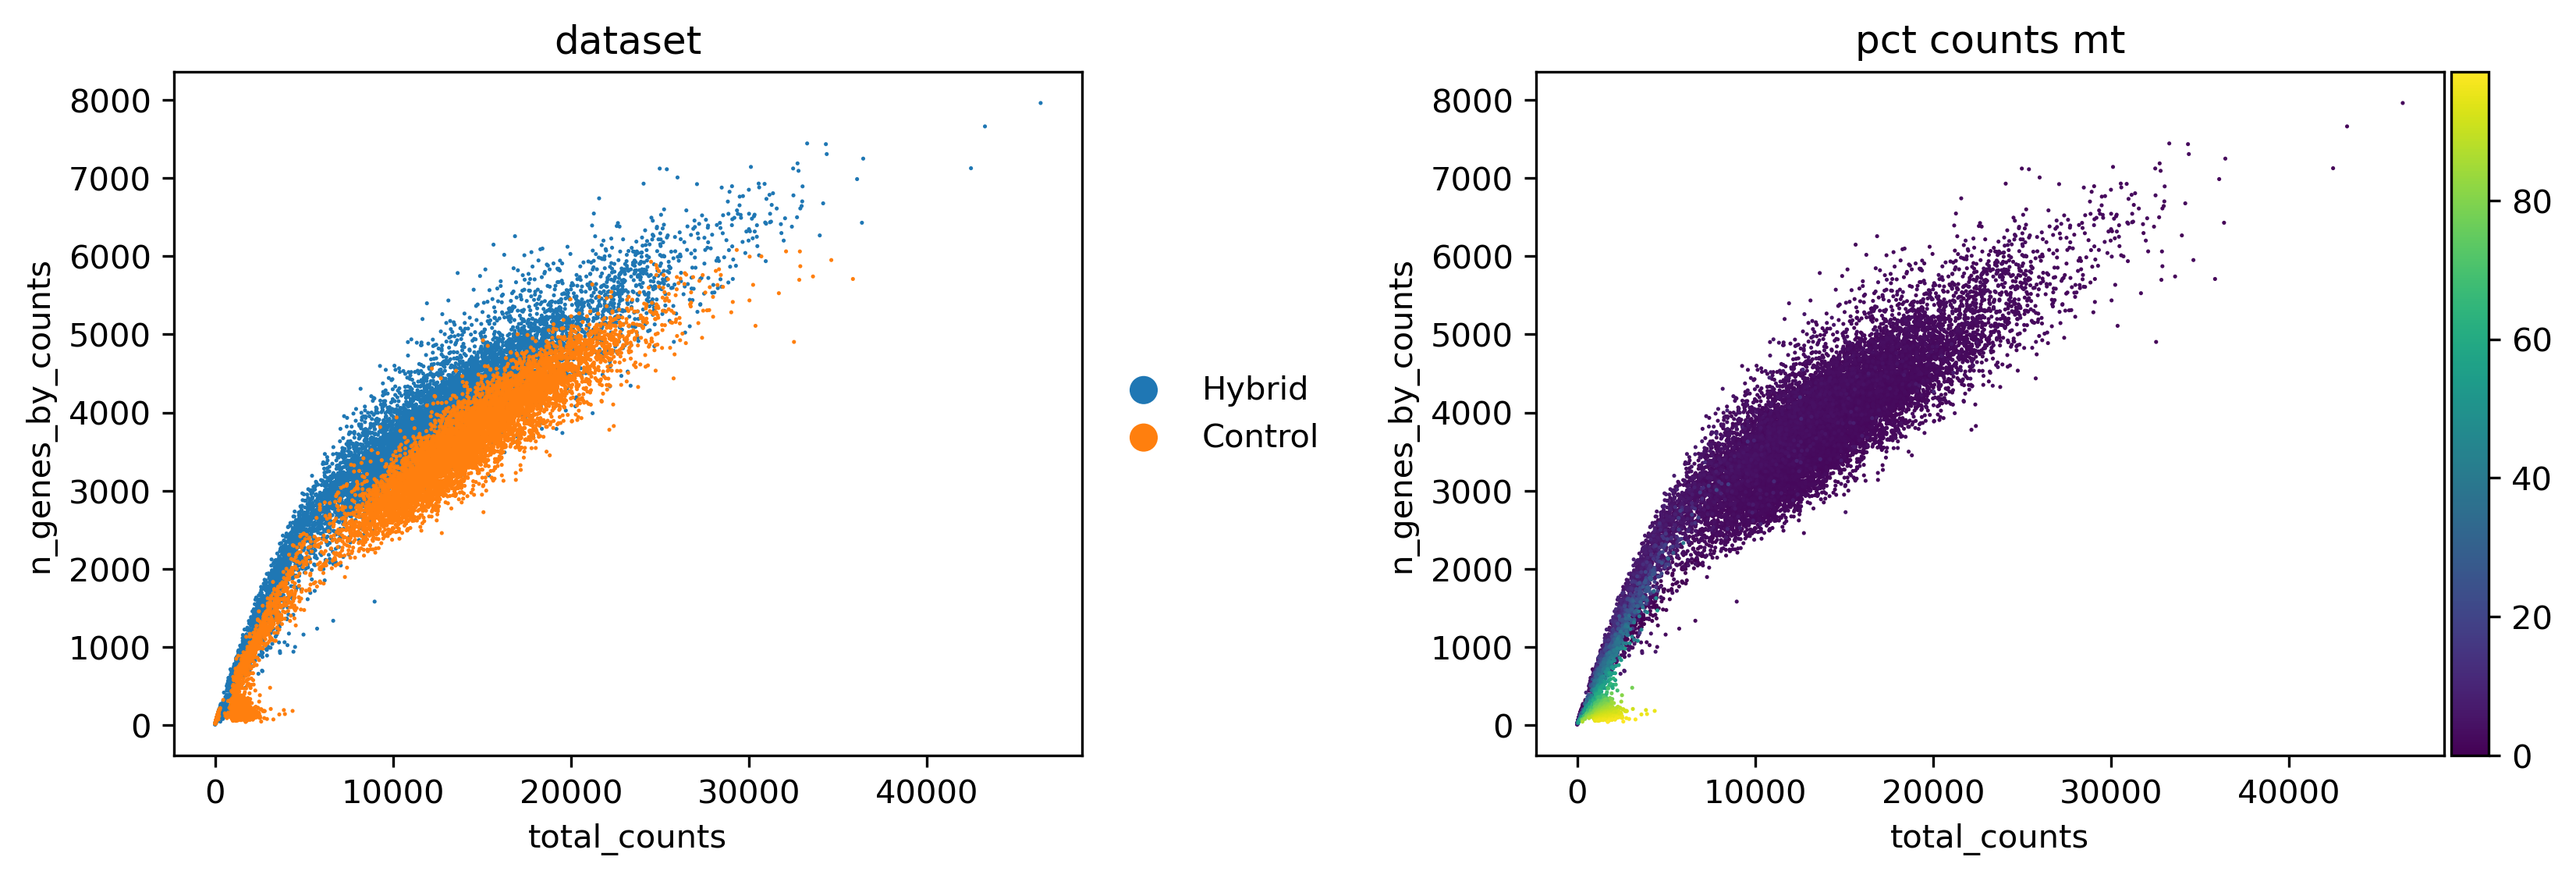

In [15]:
adata = adata_raw.copy()

# mitochondrial genes
adata.var["mt"] = adata.var_names.str.startswith("MT-")
# ribosomal genes
adata.var["ribo"] = adata.var_names.str.startswith(("RPS", "RPL"))

sc.pp.calculate_qc_metrics(adata, qc_vars=["mt", "ribo"], inplace=True, log1p=True)

plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 5, 4

sc.pl.violin(
    adata,
    ["n_genes_by_counts", "total_counts", "pct_counts_mt"],
    jitter=0.4,
    multi_panel=True,
    groupby='dataset',
)

sc.pl.scatter(adata, "total_counts", "n_genes_by_counts", color=["dataset", "pct_counts_mt"])

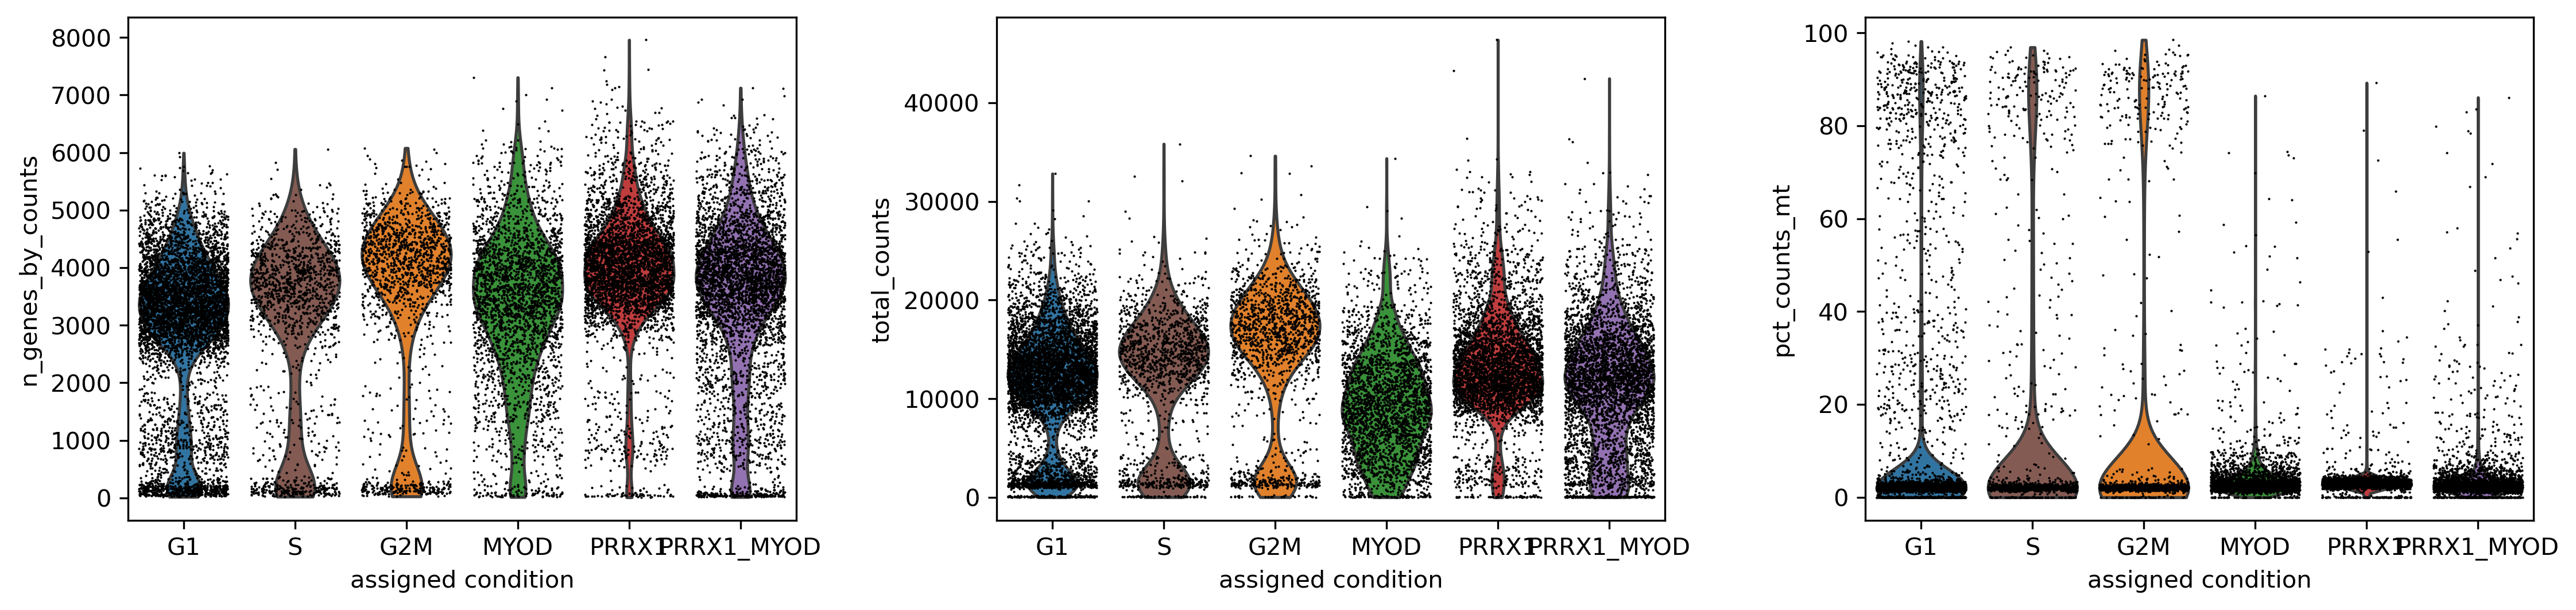

In [6]:
plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 5, 4

sc.pl.violin(
    adata,
    ["n_genes_by_counts", "total_counts", "pct_counts_mt"],
    jitter=0.4,
    multi_panel=True,
    groupby='assigned_condition',
    order=['G1', 'S', 'G2M', 'MYOD', 'PRRX1', 'PRRX1_MYOD'],
    legend=False,
)

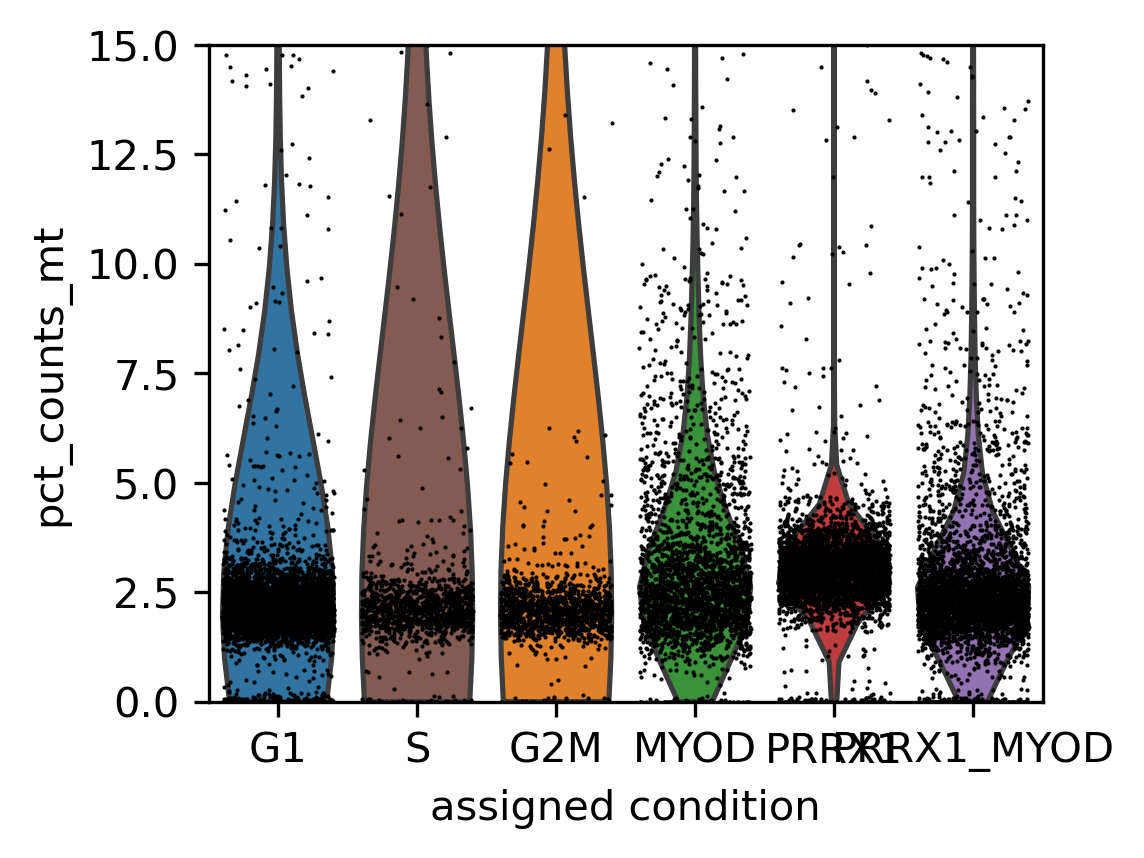

In [7]:
plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 4, 3

sc.pl.violin(
    adata,
    ["pct_counts_mt"],
    jitter=0.4,
    groupby='assigned_condition',
    order=['G1', 'S', 'G2M', 'MYOD', 'PRRX1', 'PRRX1_MYOD'],
    legend=False,
    show=False,
)

plt.ylim(0, 15) 
plt.show()

In [8]:
adata.obs.groupby('assigned_condition', observed=True)['pct_counts_mt'].agg(['mean', 'median'])

mean    median
assigned_condition                     
G1                   9.876417  2.203367
G2M                 13.439607  2.160579
MYOD                 4.083251  2.625379
PRRX1                3.354420  2.993963
PRRX1_MYOD           3.459837  2.347016
S                   13.590803  2.211606

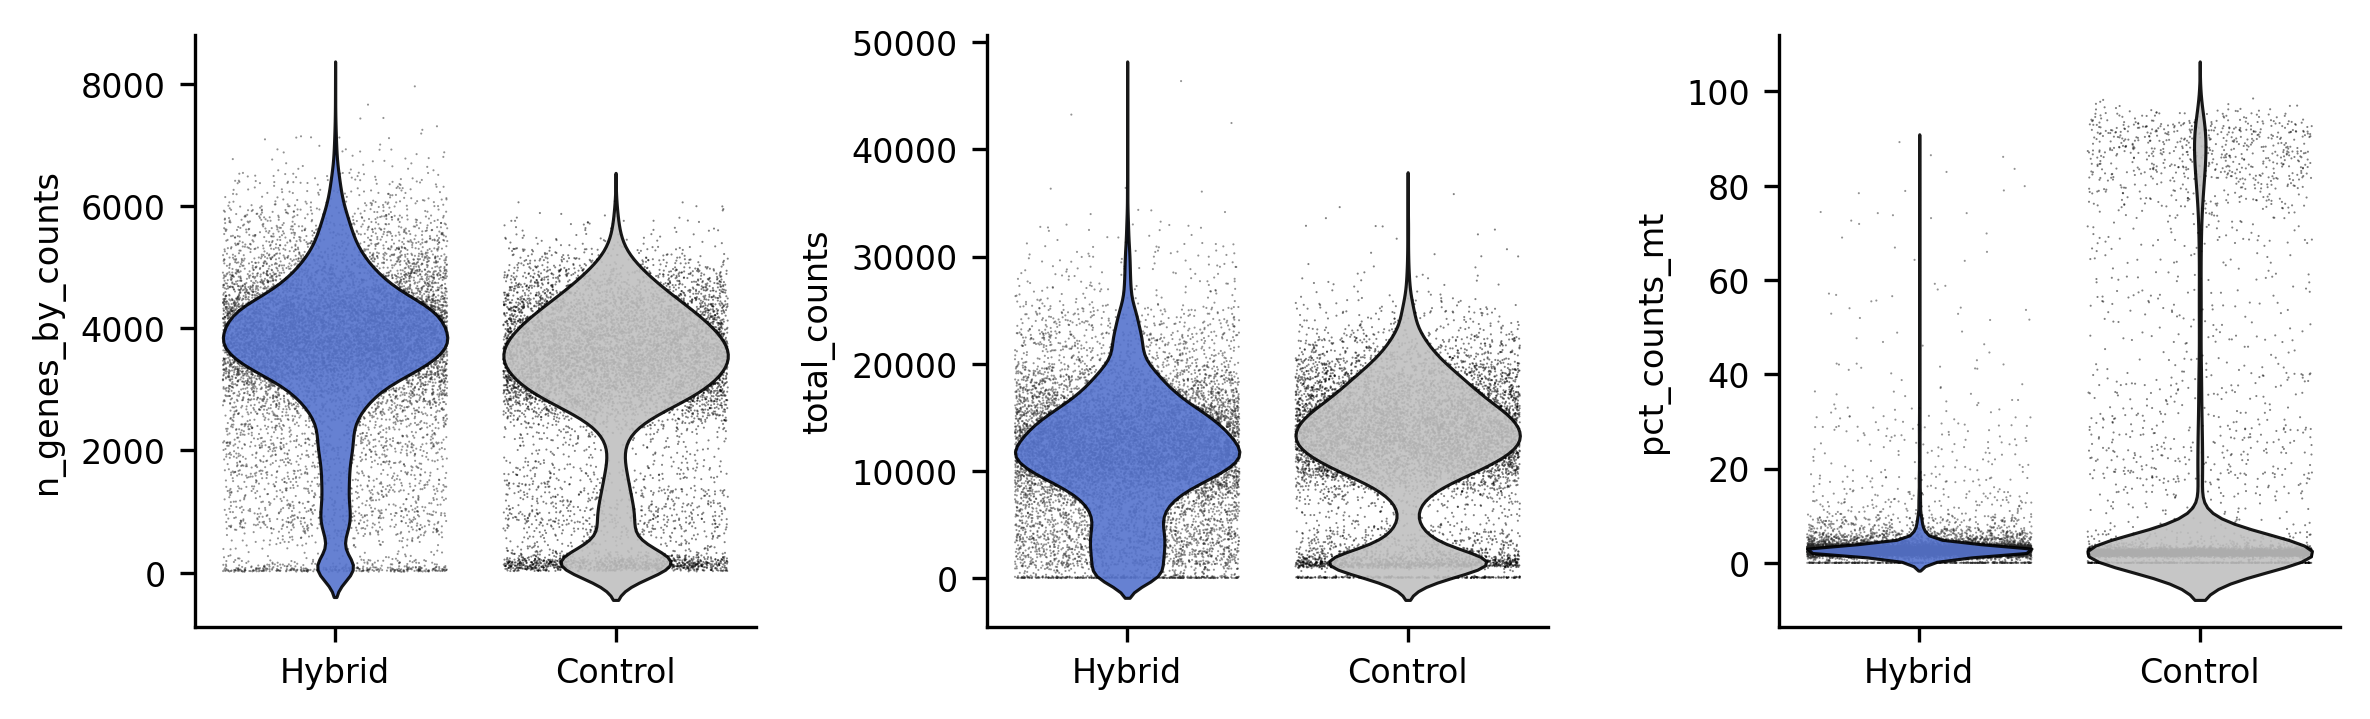

In [16]:
metrics = ['n_genes_by_counts', 'total_counts', 'pct_counts_mt']
dataset_colors = ["royalblue", "silver"]

plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = (8, 2.5)  

fig, axs = plt.subplots(1, 3, sharey=False)

for ax, metric in zip(axs, metrics):
    sns.violinplot(
        data=adata.obs,
        x='dataset',
        y=metric,
        hue='dataset',
        linewidth=0.75,
        linecolor='k',
        palette=dataset_colors,
        inner=None,
        alpha=0.9,
        zorder=1,
        ax=ax,
        legend=False,
    )

    sns.stripplot(
        data=adata.obs,
        x='dataset',
        y=metric,
        hue='dataset',
        jitter=0.4,
        palette='dark:black',
        edgecolor=None,
        size=0.5,
        alpha=0.5,
        ax=ax,
        legend=False,
        zorder=0,
    )

    ax.set_xlabel("")
    ax.set_ylabel(metric, fontsize=8)
    ax.tick_params(axis='y', labelsize=8)
    ax.set_xticklabels(ax.get_xticklabels(), fontsize=8)
    sns.despine(ax=ax)

plt.tight_layout()
plt.show()

# MAD filtering: Identify and remove low-quality cells

In [9]:
# Identify outlier cells with MADs per dataset
def is_outlier_by_group(adata, metric: str, nmads: int, group_col: str = 'dataset'):
    outlier_series = pd.Series(False, index=adata.obs.index)
    unique_groups = adata.obs[group_col].unique()

    for group in unique_groups:
        group_mask = (adata.obs[group_col] == group)
        M_group = adata.obs.loc[group_mask, metric]

        if len(M_group) < 2 or M_group.isnull().all():
            continue

        median_val_group = np.median(M_group)
        mad_val_group = median_abs_deviation(M_group)

        if mad_val_group == 0:
            continue

        outliers_in_group = (M_group < median_val_group - nmads * mad_val_group) | \
                            (median_val_group + nmads * mad_val_group < M_group)

        outlier_series.loc[group_mask] = outliers_in_group

    return outlier_series


adata.obs["outlier"] = (
    is_outlier_by_group(adata, "log1p_total_counts", 5, 'dataset')
    | is_outlier_by_group(adata, "log1p_n_genes_by_counts", 5, 'dataset')
)

print("Number of outlier cells per dataset based on counts:")
print(adata.obs.groupby('dataset', observed=True)['outlier'].sum())


adata.obs["mt_outlier"] = is_outlier_by_group(adata, "pct_counts_mt", 5, 'dataset') | (
    adata.obs["pct_counts_mt"] > 20
)

print("\nNumber of outlier cells per dataset based on pct mito:")
adata.obs.groupby('dataset', observed=True)['mt_outlier'].sum()

Number of outlier cells per dataset based on counts:
dataset
Hybrid     1184
Control    1676
Name: outlier, dtype: int64

Number of outlier cells per dataset based on pct mito:


dataset
Hybrid      788
Control    1852
Name: mt_outlier, dtype: int64

In [10]:
init_cells = adata.n_obs
init_cells_hyb = adata[adata.obs['dataset'] == 'Hybrid'].n_obs
init_cells_fib = adata[adata.obs['dataset'] == 'Control'].n_obs

print(f"Total number of cells: {init_cells}")
print(f"N cells in Hybird: {init_cells_hyb}")
print(f"N cells in Control: {init_cells_fib}")

print(f"\nFiltering...")
adata = adata[(~adata.obs.outlier) & (~adata.obs.mt_outlier)].copy()

final_cells = adata.n_obs
final_cells_hyb = adata[adata.obs['dataset'] == 'Hybrid'].n_obs
final_cells_fib = adata[adata.obs['dataset'] == 'Control'].n_obs


print(f"\nRemoved {init_cells - final_cells} total cells.")
print(f"Removed {init_cells_hyb - final_cells_hyb} from Hybrid dataset.")
print(f"Removed {init_cells_fib - final_cells_fib} from Control dataset.")


print(f"\nTotal cells after filtering of low quality cells: {final_cells}")
print(f"N cells in Hybird: {final_cells_hyb}")
print(f"N cells in Control: {final_cells_fib}")

Total number of cells: 19857
N cells in Hybird: 10894
N cells in Control: 8963

Filtering...

Removed 3490 total cells.
Removed 1487 from Hybrid dataset.
Removed 2003 from Control dataset.

Total cells after filtering of low quality cells: 16367
N cells in Hybird: 9407
N cells in Control: 6960


In [11]:
print(f"GROUPED:")
corr, pval = pearsonr(adata.obs['total_counts'], adata.obs['pct_counts_mt'])

print(f"Pearson Correlation (total_counts vs. pct_counts_mt): {corr:.4f}")
print(f"P-value: {pval:.4e}") 


corr, pval = pearsonr(adata.obs['total_counts'], adata.obs['n_genes_by_counts'])

print(f"\nPearson Correlation (total_counts vs. n_genes_by_counts): {corr:.4f}")
print(f"P-value: {pval:.4e}") 


print(f"\n\nSEPARATE:")

corr_df = adata.obs[['dataset', 'total_counts', 'n_genes_by_counts', 'pct_counts_mt']].copy()

corr_by_dataset = corr_df.groupby('dataset', observed=True).corr()
corr_by_dataset

GROUPED:
Pearson Correlation (total_counts vs. pct_counts_mt): -0.3357
P-value: 0.0000e+00

Pearson Correlation (total_counts vs. n_genes_by_counts): 0.8652
P-value: 0.0000e+00


SEPARATE:


total_counts  n_genes_by_counts  pct_counts_mt
dataset                                                                  
Hybrid  total_counts           1.000000           0.924146      -0.348091
        n_genes_by_counts      0.924146           1.000000      -0.301153
        pct_counts_mt         -0.348091          -0.301153       1.000000
Control total_counts           1.000000           0.919580      -0.168964
        n_genes_by_counts      0.919580           1.000000      -0.052543
        pct_counts_mt         -0.168964          -0.052543       1.000000

# Remove genes with low counts

In [12]:
# keep full dimension safe
adata.raw = adata  

# save raw counts
adata.layers['raw_counts'] = adata.X.copy()

print("Filtering...\n")

sc.pp.filter_genes(adata, min_counts=10)


print("\nNormalizing counts...\n")
sc.pp.normalize_total(
    adata,
    target_sum=1e4,
)

# save normalized counts
adata.layers['norm_counts'] = adata.X.copy()

# log transform normalized counts
sc.pp.log1p(adata)

# save log normalized counts
adata.layers['log_norm'] = adata.X.copy()


print(f"{adata.obs['dataset'].value_counts()}\n")
print(f"{adata.obs['pooled_condition'].value_counts()}\n")

Filtering...

filtered out 3576 genes that are detected in less than 10 counts

Normalizing counts...

normalizing counts per cell
    finished (0:00:00)
dataset
Hybrid     9407
Control    6960
Name: count, dtype: int64

pooled_condition
Control            6960
siPRRX1            3689
siPRRX1/mmMYOD1    3462
mmMYOD1            2256
Name: count, dtype: int64



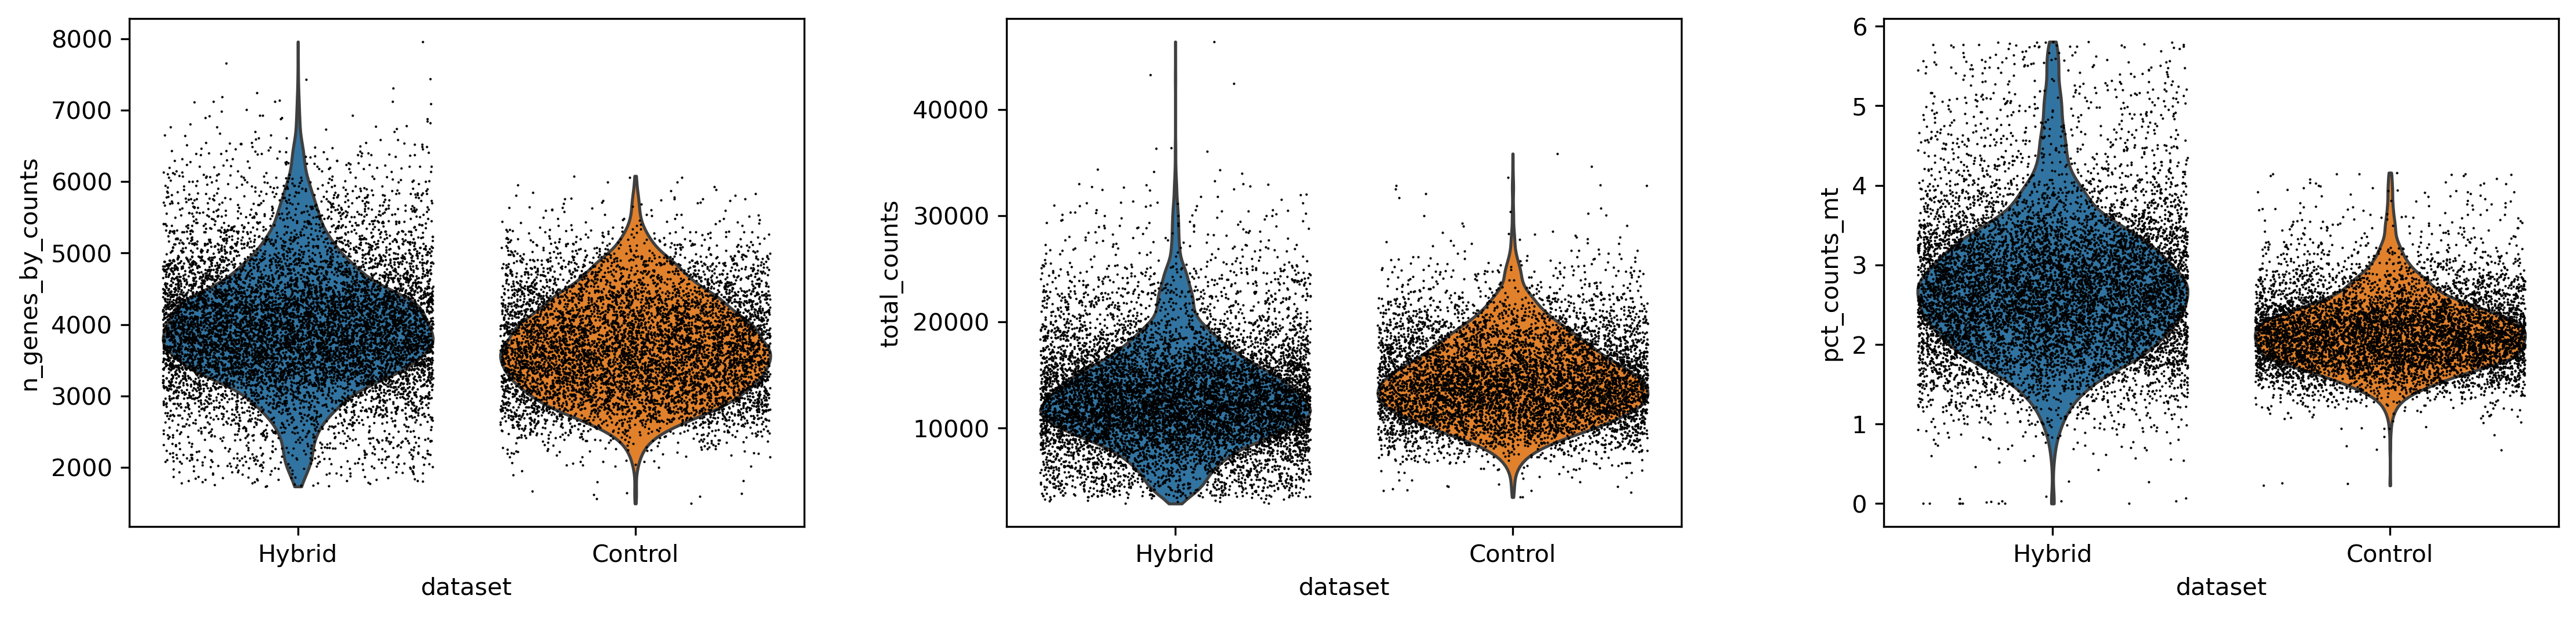

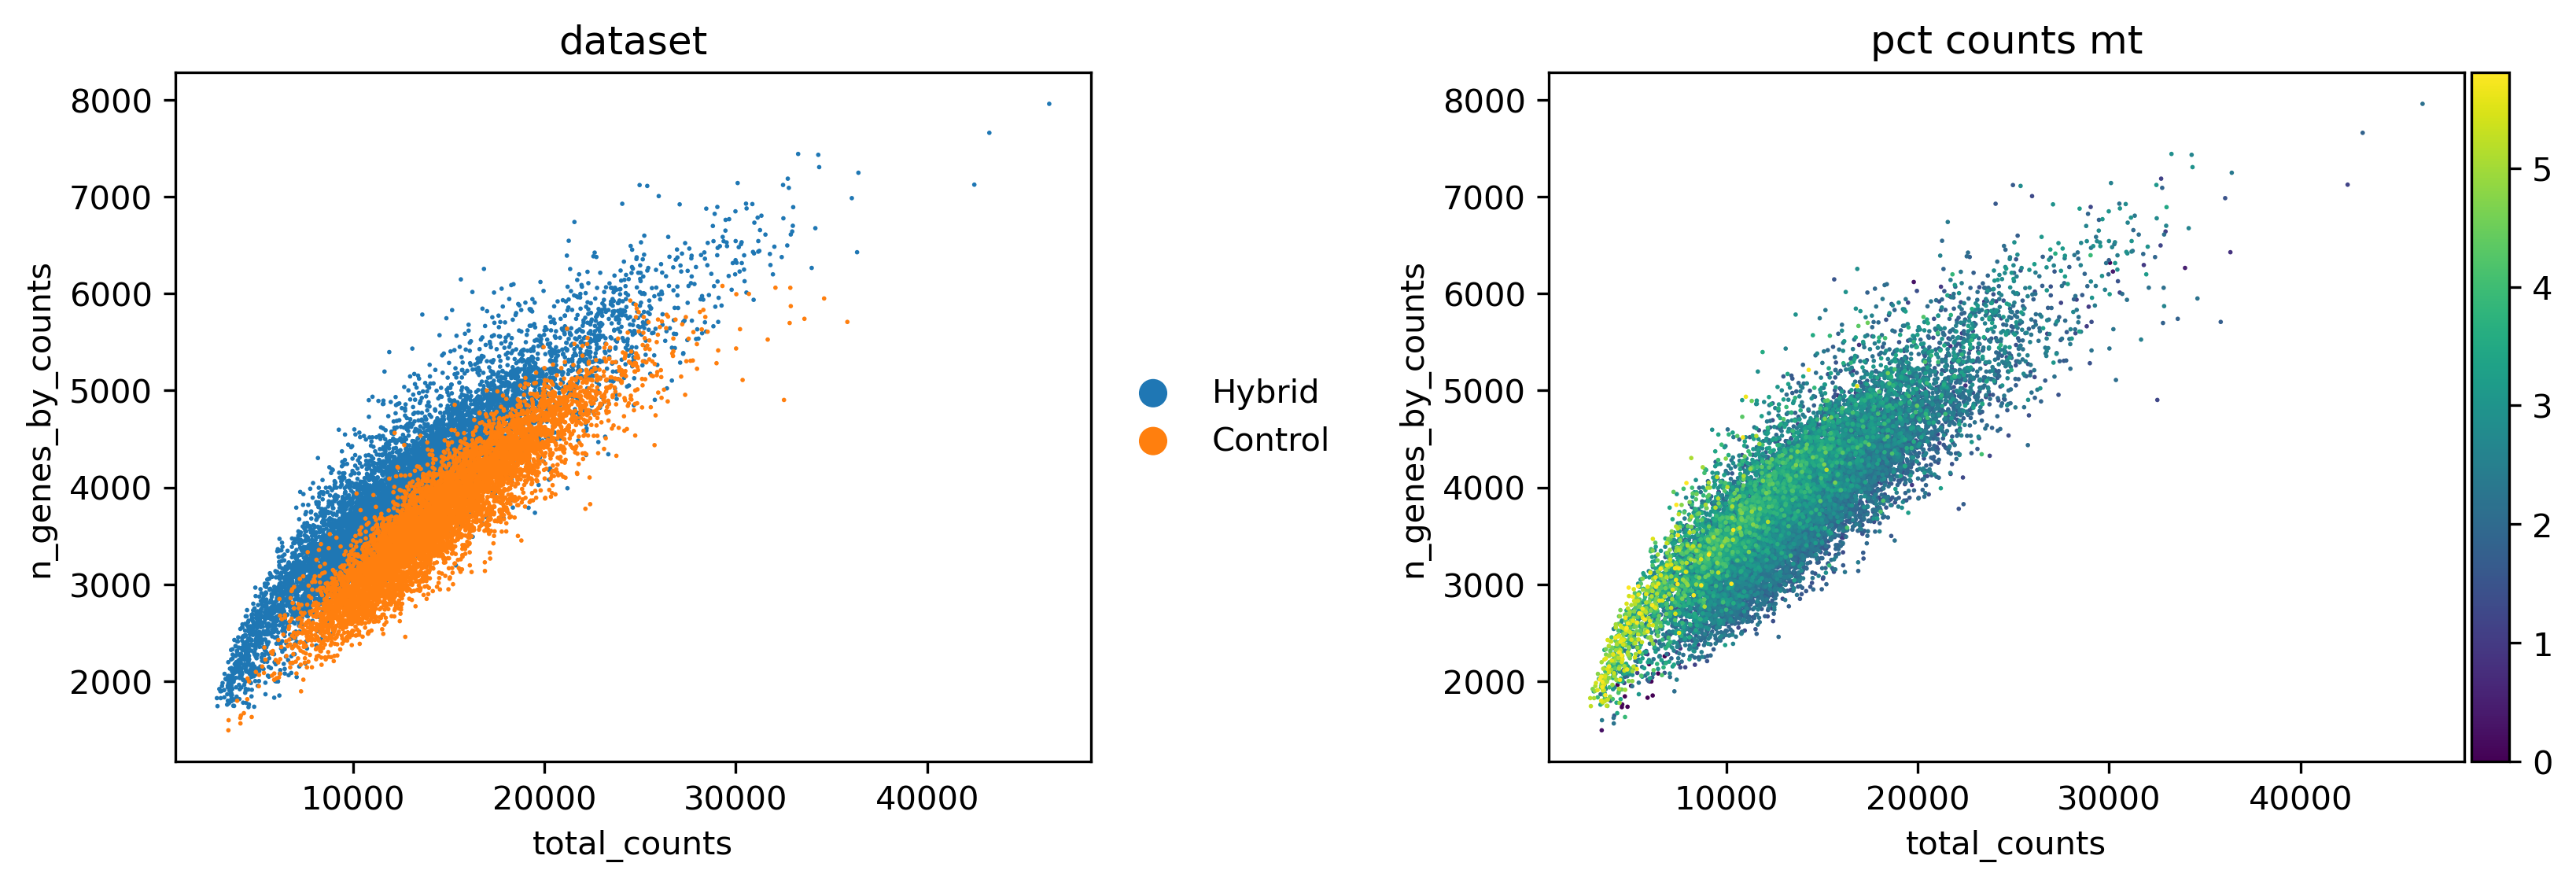

In [13]:
plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 5, 4

sc.pl.violin(
    adata,
    ["n_genes_by_counts", "total_counts", "pct_counts_mt"],
    jitter=0.4,
    multi_panel=True,
    groupby='dataset',
)

sc.pl.scatter(adata, "total_counts", "n_genes_by_counts", color=["dataset", "pct_counts_mt"])

#

# QC (separated by dataset)

In [ ]:
# hyb_adata = adata_raw[adata_raw.obs['dataset'] == 'Hybrid']
# print(f"HYB shape: {hyb_adata.shape}")
# fib_adata = adata_raw[adata_raw.obs['dataset'] == 'Control']
# print(f"scFib shape: {fib_adata.shape}")

HYBRID:



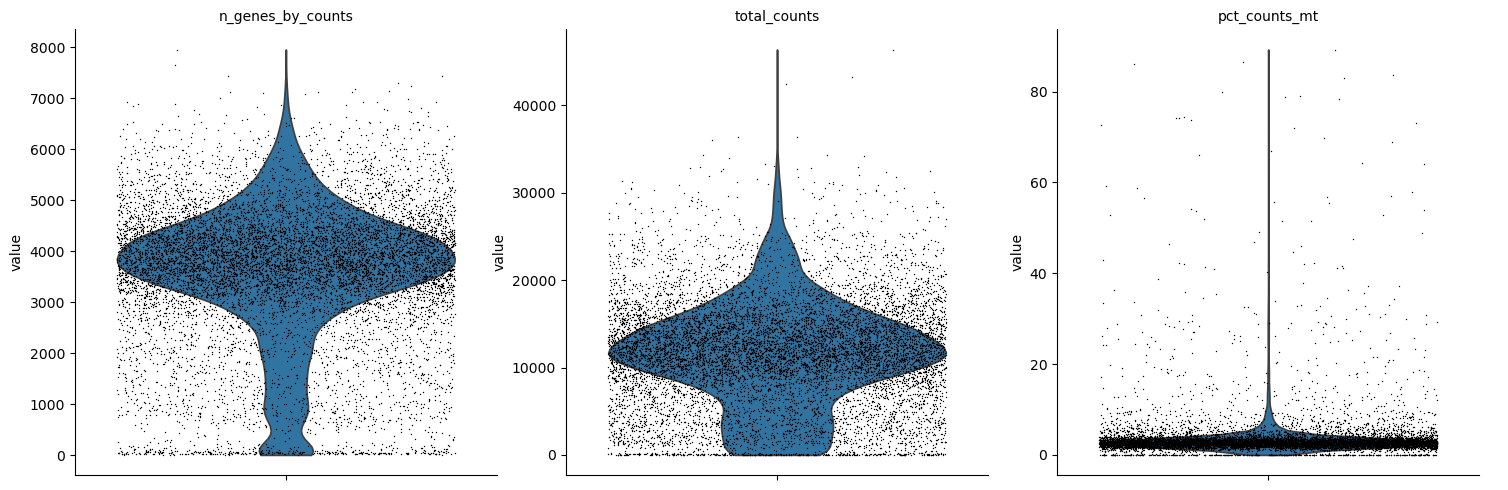

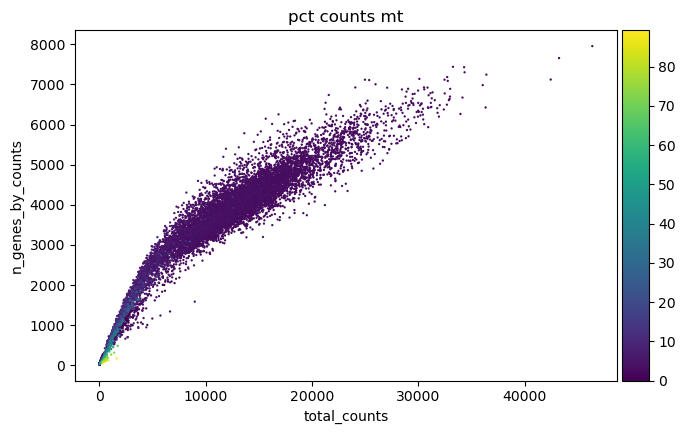

scFIB:



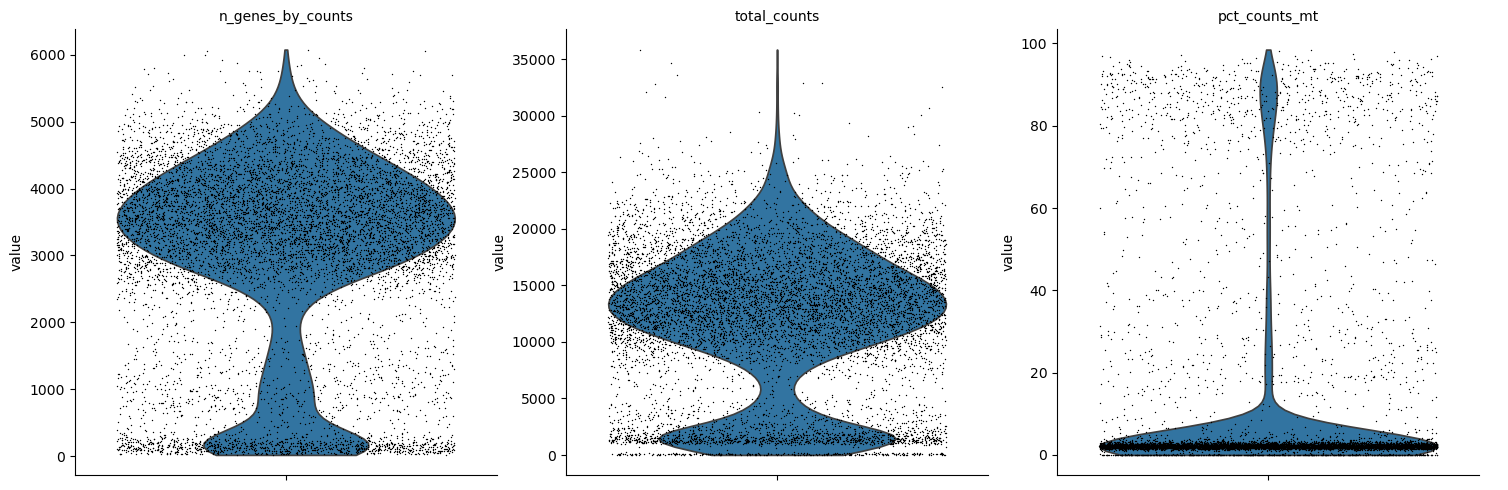

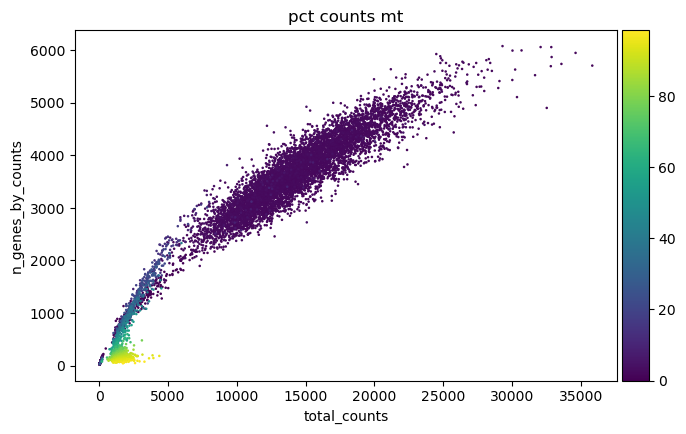

In [21]:
# ### HYB
# # mitochondrial genes
# hyb_adata.var["mt"] = hyb_adata.var_names.str.startswith("MT-")
# # ribosomal genes
# hyb_adata.var["ribo"] = hyb_adata.var_names.str.startswith(("RPS", "RPL"))

# sc.pp.calculate_qc_metrics(hyb_adata, qc_vars=["mt", "ribo"], 
#                            inplace=True, log1p=True, percent_top=[20])

# ### scFib
# fib_adata.var["mt"] = fib_adata.var_names.str.startswith("MT-")
# # ribosomal genes
# fib_adata.var["ribo"] = fib_adata.var_names.str.startswith(("RPS", "RPL"))

# sc.pp.calculate_qc_metrics(fib_adata, qc_vars=["mt", "ribo"], 
#                            inplace=True, log1p=True, percent_top=[20])


# plt.rcdefaults()

# print(f"HYBRID:\n")

# sc.pl.violin(
#     hyb_adata,
#     ["n_genes_by_counts", "total_counts", "pct_counts_mt"],
#     jitter=0.4,
#     multi_panel=True,
# )

# sc.pl.scatter(hyb_adata, "total_counts", "n_genes_by_counts", color="pct_counts_mt")

# print(f"scFIB:\n")

# sc.pl.violin(
#     fib_adata,
#     ["n_genes_by_counts", "total_counts", "pct_counts_mt"],
#     jitter=0.4,
#     multi_panel=True,
# )

# sc.pl.scatter(fib_adata, "total_counts", "n_genes_by_counts", color="pct_counts_mt")

## MAD filtering: by dataset

In [28]:
# def is_outlier(adata, metric: str, nmads: int):
#     M = adata.obs[metric]
#     outlier = (M < np.median(M) - nmads * median_abs_deviation(M)) | (
#         np.median(M) + nmads * median_abs_deviation(M) < M
#     )
#     return outlier

# n_mads = 5

# hyb_adata.obs["outlier"] = (
#     is_outlier(hyb_adata, "log1p_total_counts", n_mads)
#     | is_outlier(hyb_adata, "log1p_n_genes_by_counts", n_mads)
#     # | is_outlier(hyb_adata, "pct_counts_in_top_20_genes", 5)
# )

# hyb_adata.obs.outlier.value_counts()

outlier
False    9710
True     1184
Name: count, dtype: int64

In [29]:
# hyb_adata.obs["mt_outlier"] = is_outlier(hyb_adata, "pct_counts_mt", 3) | (
#     hyb_adata.obs["pct_counts_mt"] > 8
# )
# hyb_adata.obs.mt_outlier.value_counts()

mt_outlier
False    9222
True     1672
Name: count, dtype: int64

Lower MAD threshold for log1p_total_counts: 7.97
Upper MAD threshold for log1p_total_counts: 10.77


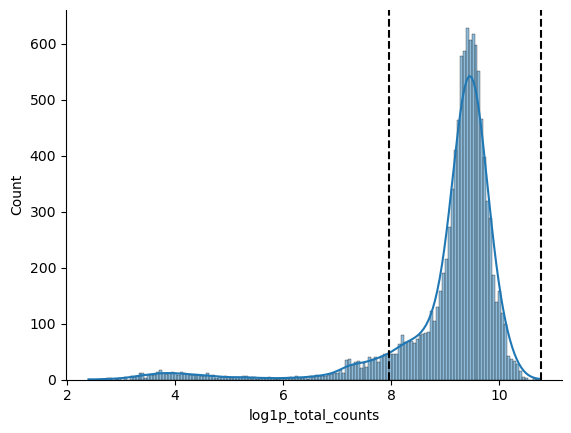

In [25]:
# def is_outlier_thresholds(adata, metric: str, nmads: int):
#     M = adata.obs[metric]
#     median_val = np.median(M)
#     mad_val = median_abs_deviation(M)
#     lower_threshold = median_val - nmads * mad_val
#     upper_threshold = median_val + nmads * mad_val
#     return lower_threshold, upper_threshold

# lower_bound, upper_bound = is_outlier_thresholds(hyb_adata, 'log1p_total_counts', n_mads)

# print(f"Lower MAD threshold for log1p_total_counts: {lower_bound:.2f}")
# print(f"Upper MAD threshold for log1p_total_counts: {upper_bound:.2f}")

# sns.histplot(
#     hyb_adata.obs,
#     x=hyb_adata.obs['log1p_total_counts'],
#     kde=True,
# )

# plt.axvline(x=lower_bound, color='k', linestyle='--')
# plt.axvline(x=upper_bound, color='k', linestyle='--')

# sns.despine()

Lower MAD threshold for log1p_n_genes_by_counts: 7.45
Upper MAD threshold for log1p_n_genes_by_counts: 9.02


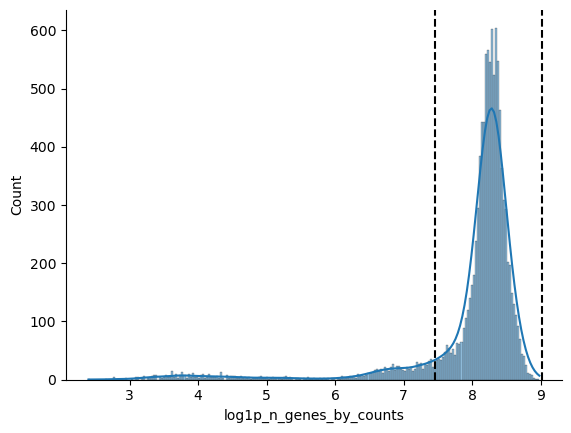

In [26]:
# lower_bound, upper_bound = is_outlier_thresholds(hyb_adata, 'log1p_n_genes_by_counts', n_mads)

# print(f"Lower MAD threshold for log1p_n_genes_by_counts: {lower_bound:.2f}")
# print(f"Upper MAD threshold for log1p_n_genes_by_counts: {upper_bound:.2f}")

# sns.histplot(
#     hyb_adata.obs,
#     x=hyb_adata.obs['log1p_n_genes_by_counts'],
#     kde=True,
# )

# plt.axvline(x=lower_bound, color='k', linestyle='--')
# plt.axvline(x=upper_bound, color='k', linestyle='--')

# sns.despine()

Lower MAD threshold for pct_counts_mt: 0.85
Upper MAD threshold for pct_counts_mt: 4.57


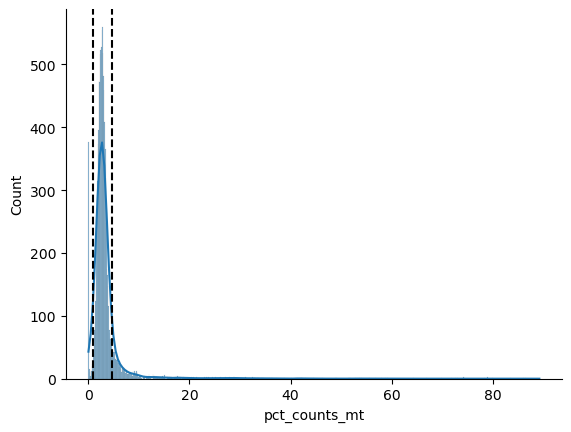

In [27]:
# lower_bound, upper_bound = is_outlier_thresholds(hyb_adata, 'pct_counts_mt', 3)

# print(f"Lower MAD threshold for pct_counts_mt: {lower_bound:.2f}")
# print(f"Upper MAD threshold for pct_counts_mt: {upper_bound:.2f}")

# sns.histplot(
#     hyb_adata.obs,
#     x=hyb_adata.obs['pct_counts_mt'],
#     kde=True,
# )

# plt.axvline(x=lower_bound, color='k', linestyle='--')
# plt.axvline(x=upper_bound, color='k', linestyle='--')

# sns.despine()

In [15]:
# fib_adata.obs["outlier"] = (
#     is_outlier(fib_adata, "log1p_total_counts", 5)
#     | is_outlier(fib_adata, "log1p_n_genes_by_counts", 5)
#     # | is_outlier(fib_adata, "pct_counts_in_top_20_genes", 5)
# )

# fib_adata.obs.outlier.value_counts()

outlier
False    7287
True     1676
Name: count, dtype: int64

In [16]:
# fib_adata.obs["mt_outlier"] = is_outlier(fib_adata, "pct_counts_mt", 3) | (
#     fib_adata.obs["pct_counts_mt"] > 8
# )
# fib_adata.obs.mt_outlier.value_counts()

mt_outlier
False    6921
True     2042
Name: count, dtype: int64

In [30]:
# print(f"Total number of cells: {hyb_adata.n_obs}")
# init_cells = hyb_adata.n_obs

# hyb_adata = hyb_adata[(~hyb_adata.obs.outlier) & (~hyb_adata.obs.mt_outlier)].copy()
# final_cells = hyb_adata.n_obs

# print(f"Removed {init_cells - final_cells}")
# print(f"Number of cells after filtering of low quality cells: {hyb_adata.n_obs}")

Total number of cells: 10894
Removed 1887
Number of cells after filtering of low quality cells: 9007


In [31]:
# hyb_adata.obs['assigned_condition'].value_counts()

assigned_condition
PRRX1         3638
PRRX1_MYOD    3308
MYOD          2061
Name: count, dtype: int64

In [34]:
# pearson_corr, pearson_p_value = pearsonr(hyb_adata.obs['total_counts'], hyb_adata.obs['pct_counts_mt'])

# print(f"Pearson Correlation (total_counts vs. pct_counts_mt): {pearson_corr:.4f}")
# print(f"P-value: {pearson_p_value:.4e}") 

# pearson_corr, pearson_p_value = pearsonr(hyb_adata.obs['total_counts'], hyb_adata.obs['n_genes_by_counts'])

# print(f"\nPearson Correlation (total_counts vs. n_genes_by_counts): {pearson_corr:.4f}")
# print(f"P-value: {pearson_p_value:.4e}") 

Pearson Correlation (total_counts vs. pct_counts_mt): -0.2628
P-value: 3.7129e-142

Pearson Correlation (total_counts vs. n_genes_by_counts): 0.9202
P-value: 0.0000e+00


In [18]:
# print(f"Total number of cells: {fib_adata.n_obs}")
# init_cells = fib_adata.n_obs

# fib_adata = fib_adata[(~fib_adata.obs.outlier) & (~fib_adata.obs.mt_outlier)].copy()
# final_cells = fib_adata.n_obs

# print(f"Removed {init_cells - final_cells}")
# print(f"Number of cells after filtering of low quality cells: {fib_adata.n_obs}")

Total number of cells: 8963
Removed 2137
Number of cells after filtering of low quality cells: 6826
